<center><h1>UVA Psychology Capstone   </h1></center>
<center><h1>Brain Computer Interface with Scale Invariant Temporal History</h1></center>

#### A preliminary Deep_iSith model that trains on EEG data.
Yibo Wang,  Gaurav Anand, Arshiya Ansari, Beverly Dobrenz   

1. **Data source: Grasp-and-Lift EEG**  
https://www.kaggle.com/c/grasp-and-lift-eeg-detection/data  

2. **Methods**  
For now, only consider one subject (subject1) for modeling.
Predict only one event/channel a time (since there are events overlapping), and incorporate sliding-window standardization and filtering.  
Load all eight events and split into 80% training and 20% validation/holdout set.  
Use *dataset* and *dataloader* pytorch classes to control batch processing.  
Use sequence length of 50000 and stride size of 5000 (overlaped sequence for each batch)for each minibatch.  
3. **Note**  
The code is tested on Rivanna with GPU. (may needs some tweeks with CPU only)  
Need train_util.py and Deep_isith_EEG.py helper functions as well as the SITH_Layer_master package

4. **Github repository**  
https://github.com/gauvand/SIF_Capstone  
https://github.com/compmem/SITH_Layer   

In [11]:
from train_util import *
from Deep_isith_EEG import *
import warnings
warnings.filterwarnings('ignore')

## Read data and prepare the data for training and testing
Deep_isith model v3: try to predict event one at a time since some events are overlapping.   
    The **input** signal needs to be in correct format: **[nbatch x 1 x nfeutures x timeSeq]** pytorch tensor.
    The inputs to the models are the time series EEG signals. All channels will be
    concatnated into one channel by iSith.    
    The **targets** are inputed separately with **[nClasses x time]**  tensor. The target is either 0 or 1 at any time point for each event channel.
    **Note: Dimention of the input tensors  (batch, MAGIC, features, sequence). The second "magic" dimention will always be 1 in order for this to quickly calculate the output of the SITH layer.**     
    For this model batch should be one because we only feed one trial of one subject.    
    channels 32 to 38 are targets, for this model. Only predict one event a time
    demonstate using the second class is "First digit touch" as an example

In [14]:
# try weighted loss 
# ##### test with weighted cross entropy#####
# # use weight inversely porportioned to their count in the data
# _,count = np.unique(train_y_t.detach().cpu().numpy(),
#                     return_counts=True)
# total = count[0] + count[1]
# weights = torch.cuda.DoubleTensor([1/(count[0]/total),1/(count[1]/total)])
# print("weights:", weights)
# loss_func =  torch.nn.CrossEntropyLoss(weight = weights,reduction='mean')
# ############################################

In [16]:
# parameters
results = []
dir = "./grasp-and-lift-eeg-detection/"
kernel_size = 50000 # sliding window size to use
step = 45000 #  --the step between each slice. means overlap between batches is 1- step 
# num of epochs to train
nepochs = 12
# Just for visualizing average loss through time. 
loss_buffer_size = 100
loss_func =  torch.nn.CrossEntropyLoss()
batch_size = 2 # batch_size is a hyper parameter to tune 
train_split = 0.8
lr = 0.01


# start training
for i in range(1,7): # There are six events 1 - 6
    nClass = i

    train_x_list = []
    train_y_list = []

    for file in os.listdir(dir):
        if file[:-4].endswith('_data'):
            raw = creat_mne_raw_object(dir+file,read_events=True)
            input_tensor,target_tensor = filter_standardization(raw,window_size = 1000,
                              l_freq = 0,h_freq = 30,nClass = nClass)
            input_tensor = input_tensor.squeeze()
            # patches data 
            patches_train = input_tensor.unfold(dimension = 1, size = kernel_size, step = step).permute(1,0,2)
            patches_label = target_tensor.unfold(0, kernel_size, step)
            #print(patches_train.shape, patches_label.shape)

            # append to a list
            train_x_list.append(patches_train)
            train_y_list.append(patches_label)  
    print("Finished ! {} data are loaded".format(len(train_x_list)))
    print("Processing event number {}".format(nClass))
    
    # concatenate them
    train_x_t = torch.cat(train_x_list, dim=0)
    train_y_t = torch.cat(train_y_list, dim=0)
    print(train_x_t.shape, train_y_t.shape)


    # create dataloader class
    train_loader,val_loader = split_train_val(train_x_t ,train_y_t,
                    batch_size = batch_size, train_split = train_split)
    
    #--------------- sith layer model parameters ------------------#
    # make sure this in_features matches the number of feutures in the EEG data
    sith_params1 = {"in_features":32, 
                    "tau_min":1, "tau_max":150, 
                    "k":15, 'dt':1,
                    "ntau":8, 'g':0.0,  
                    "ttype":ttype, 
                    "hidden_size":25, "act_func":nn.ReLU()}

    sith_params2 = {"in_features":sith_params1['hidden_size'], 
                    "tau_min":1, "tau_max":150.0, 'buff_max':600, 
                    "k":4, 'dt':1,
                    "ntau":8, 'g':0.0, 
                    "ttype":ttype, 
                    "hidden_size":25, "act_func":nn.ReLU()}
    layer_params = [sith_params1, sith_params2]

    #------------------ model configuration ------------------------#
    # number of output feature should be 2 since we always train one at a time, so now 1+1
    model = DeepSITH_Tracker(out=2,
                                layer_params=layer_params, 
                                dropout=0.1).double()
    optimizer = torch.optim.Adam(model.parameters())
    # map model to GPU
    device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    #------------------- start training ---------------------------#
    perf = []
    perf = train_model(model, ttype, train_loader, val_loader,
                    optimizer, loss_func, epochs=nepochs)
    results.append(perf)

Finished ! 8 data are loaded
Processing event number 1
torch.Size([26, 32, 50000]) torch.Size([26, 50000])



Finished ! 8 data are loaded
Processing event number 2
torch.Size([26, 32, 50000]) torch.Size([26, 50000])



Finished ! 8 data are loaded
Processing event number 3
torch.Size([26, 32, 50000]) torch.Size([26, 50000])



Finished ! 8 data are loaded
Processing event number 4
torch.Size([26, 32, 50000]) torch.Size([26, 50000])



Finished ! 8 data are loaded
Processing event number 5
torch.Size([26, 32, 50000]) torch.Size([26, 50000])



Finished ! 8 data are loaded
Processing event number 6
torch.Size([26, 32, 50000]) torch.Size([26, 50000])


## Define training, testing functions, and Deep_sith models
**Training**:
Currently using minibatch gradient descent. batchsize is controled above   
**Validation**:   
The performance metric used here is **AUC** since the data is unbanlanced and used in the competition.  
Signals need to be in correct format. validation input: [nbatch x 1 x nFeutures x seq_length] tensor.
The validation target has dimension of [nbatch x seq_length] tensor, in which each entry should be binary.

#### Average AUC on the holdout set for all six events for Subject1

In [19]:
(0.92444 + 0.98796 + 0.97599+0.98804+0.98143+0.96675)/6

0.9707683333333335

## Plot training result

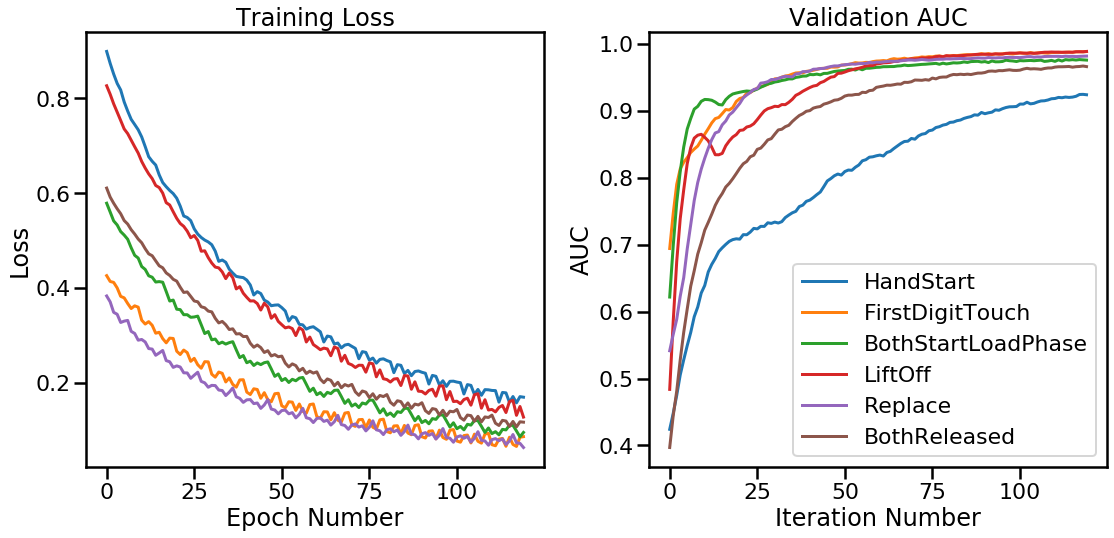

In [18]:
fig = plt.figure(figsize=(16, 8),constrained_layout=False)
event = ['HandStart','FirstDigitTouch','BothStartLoadPhase',
            'LiftOff','Replace','BothReleased']
for i in range(len(results)):
    perf = results[i]
    # build a dataframe
    loss = np.array(perf['loss'])
    acc = np.array(perf['acc'])
    iteration = np.array(perf['iteration'])
    final_result = pd.DataFrame({'iteration' : iteration,'loss' : loss, 'accuracy' : acc}) 
    final_result.head()
    
    ax = fig.add_subplot(121)
    sn.lineplot(data=final_result, x='iteration', y='loss',
                ax=ax)
    ax.set_xlabel("Epoch Number")
    ax.set_ylabel("Loss")
    ax.set_title("Training Loss")


    ax = fig.add_subplot(122)
    sn.lineplot(data=final_result, x='iteration', y='accuracy', 
                legend='brief', label=event[i], ax=ax)
    ax.set_xlabel("Iteration Number")
    ax.set_ylabel("AUC")
    ax.set_title("Validation AUC")
    plt.tight_layout()

plt.show()

## Model evaluation


In [23]:
test_X, y_true = next(iter(val_loader))

In [35]:
out_val =model(test_X)

# pass through a softmax to tansform to probability
res = torch.nn.functional.softmax(out_val, dim=2)

# index the probability of 1s
y_pred = res[:,:,1]
y_score = np.ndarray.flatten(y_pred.detach().cpu().numpy())
y_true = np.ndarray.flatten(y_true.detach().cpu().numpy())

In [36]:
print(y_score.shape,y_true.shape)

(100000,) (100000,)


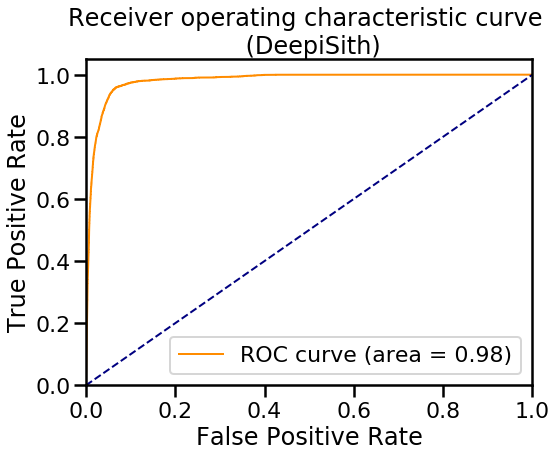

In [37]:
roc_auc = roc_auc_score(y_true = y_true,y_score = y_score)
fpr, tpr, _ = roc_curve(y_true = y_true,y_score = y_score)
plt.figure(figsize=(8, 6))
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic curve \n (DeepiSith)')
plt.legend(loc="lower right")
plt.show()